## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals. 

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories. 

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks] 



In [4]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2024
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [11]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [ ]:
import random

# Set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 


# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = "animal/dataset/dataset"
classes = os.listdir(data_dir)

In [ ]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

Size of training dataset : 6270
torch.Size([3, 112, 112])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1745567..2.3031092].


Label:  ailurus-fulgens (5)


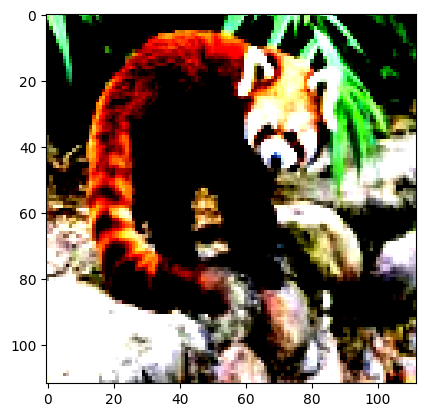

In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

show_image(*dataset[200])

In [ ]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.

#Set seed for reproducibility
set_seed(42)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  


batch_size = 16 # Define batch size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2467773..2.3572743].


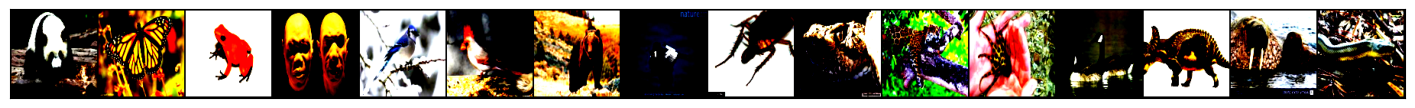

In [ ]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        acc = accuracy(out, labels, (1,))[0] # calculate accuracy, return top 1 accuracy
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))[0]   # Calculate accuracy, return top 5 accuracy
        return {'loss': loss.detach(), 'acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, loss: {:.4f}, acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['loss'], result['acc'])) ## Change

**Changes explanation**:

```
def training_step(self, batch)
```
Changes:

1. Add accuracy calculation `accuracy = accuracy(out, labels, (1,))`

2. Return loss and accuracy

Reasons: It is better to observe both training loss and training accuracy to evaluate and modify the model if it is needed


```
def epoch_end(self, epoch, result)
```

Changes: `epoch` -> `epoch + 1`

Reasons: Using epoch + 1 in the epoch_end method is a common practice to ensure that the epoch count starts from 1 instead of 0 when printed. This is more intuitive and user-friendly because most people expect counting to start from 1 rather than 0

In [ ]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

device = get_default_device()
device

device(type='cuda')

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
# Initiate the data loader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# Initiate and model printing
num_classes = 151
model = ConvolutionalNetwork(num_classes)

model = to_device(model, device)
model


ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0330, -5.0304, -5.0173, -4.9921, -5.0377, -5.0028, -5.0308, -4.9716,
        -4.9510, -5.0031, -5.0243, -5.0337, -5.0463, -5.0406, -4.9950, -4.9499,
        -5.0462, -5.0435, -5.0321, -5.0747, -4.9957, -5.0128, -5.0194, -5.0369,
        -5.0000, -5.0023, -4.9400, -5.0418, -4.9725, -5.0005, -4.9809, -5.0254,
        -4.9562, -5.0289, -4.9446, -4.9725, -5.0738, -5.0004, -4.9788, -5.0104,
        -4.9815, -5.0167, -4.9924, -5.0690, -5.0053, -5.0041, -4.9812, -5.0109,
        -5.0153, -5.0320, -5.0232, -5.0164, -5.1000, -5.0366, -4.9501, -5.0584,
        -5.0446, -4.9780, -4.9509, -5.0156, -5.0607, -5.0596, -5.0116, -4.9944,
        -4.9863, -4.9938, -5.0141, -5.0161, -5.0435, -5.0470, -4.9844, -5.0580,
        -5.0133, -4.9939, -5.0568, -5.0446, -5.0566, -4.9752, -4.9958, -5.0605,
        -4.9952, -5.0207, -5.0145, -5.0777, -5.0375, -4.9840, -5.0064, -5.0902,
        -4.9951, -5.0508, -5.0038, 

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        training_accuracy = []
        for batch in tqdm(train_loader):
            training_result = model.training_step(batch)
            loss = training_result['train_loss']
            accuracy = training_result['train_acc']
            train_losses.append(loss)
            training_accuracy.append(accuracy)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(training_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Changes explanation**

```
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD)
```

Changes:

1. Initiate a list to store the training accuracy `training_accuaracy`

2. Access to the tuples given from the function `training_step` of the object from class `Convolutional Network`

Reason: Since the accuracy is initiated to be returned from the functiom `training step`, thus the list storing and data access are also created


In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)

# Initiate the number of epoches and optimizater, learning rate
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
# Initiate hiostory to store the results after each epoch
history = []
history+= fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8508, loss: 4.5725, acc: 0.1111


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.3940, loss: 4.2944, acc: 0.1580


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.9313, loss: 4.0100, acc: 0.2681


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.4889, loss: 3.8528, acc: 0.2892


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.0617, loss: 3.7994, acc: 0.3205


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.6592, loss: 4.0149, acc: 0.3149


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3322, loss: 4.1782, acc: 0.3535


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.0355, loss: 4.2973, acc: 0.3142


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.7400, loss: 4.6924, acc: 0.3611


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.5222, loss: 4.6414, acc: 0.3486


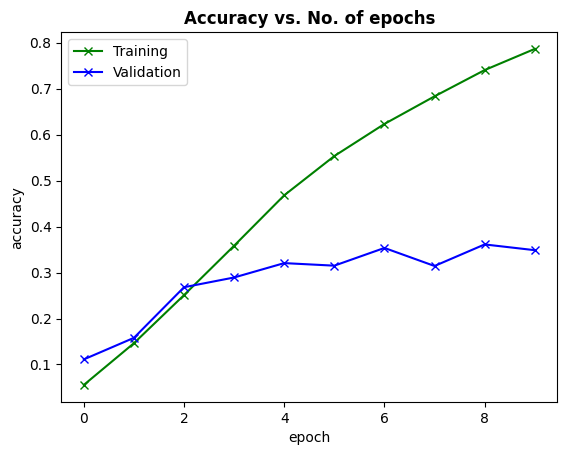

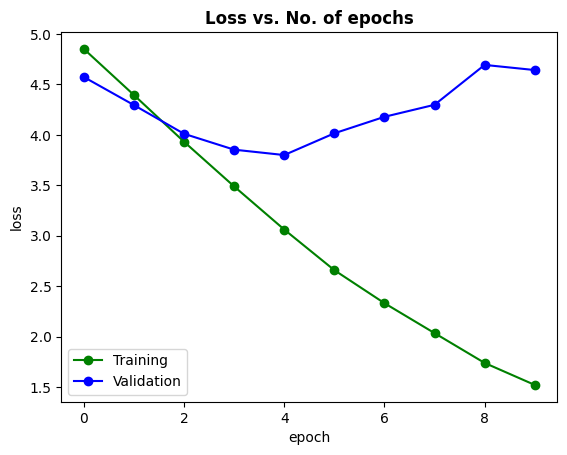

In [ ]:
# Plot the history of accuracy
def plot_accuracies(history):
    train_accuracies = [x.get('train_acc') for x in history]
    val_accuracies = [x['acc'] for x in history]
    plt.plot(train_accuracies, '-gx')  # Green for training accuracy
    plt.plot(val_accuracies, '-bx')    # Blue for validation accuracy
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs', fontweight = 'bold')
    plt.show()
    
# Plot the history of loss
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['loss'] for x in history]
    plt.plot(train_losses, '-go')  # Green for training loss
    plt.plot(val_losses, '-bo')    # Blue for validation loss
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs', fontweight = 'bold')
    plt.show()

#Plotting
plot_accuracies(history)
plot_losses(history)


In [ ]:
baseline_test_acc = evaluate(model, test_loader)
baseline_test_acc

# Print test acccuracy
print(f'Baseline Model - Accuracy for test data: {(baseline_test_acc['acc']*100)}% with the loss {baseline_test_acc['loss']}')

Baseline Model - Accuracy for test data: 36.09375059604645% with the loss 4.767521858215332


##FLOPs

In [ ]:
from fvcore.nn.flop_count import FlopCountAnalysis

def get_gflops(model, input_size):
    input_tensor = torch.randn(1, 3, input_size, input_size)
    flops = FlopCountAnalysis(model, input_tensor).total()
    gflops = flops / 1e9
    return gflops

# Get flops and efficiency score for baseline model

gflops_baseline = get_gflops(ConvolutionalNetwork(151), 112)
print(f"Baseline model FLOPs: {gflops_baseline} GFLOPs")

efficiency_baseline = baseline_test_acc['acc'] / gflops_baseline
print(f"Baseline model efficiency score: {efficiency_baseline} (acc%/GFLOPs)")

Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::log_softmax encountered 1 time(s)


Baseline model FLOPs: 0.355511168 GFLOPs
Baseline model efficiency score: 1.0152634810067753 (acc%/GFLOPs)


In [ ]:
# Initiate data augmentation on train dataset and validation dataset
augmented_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.3),  
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augmented_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data = ImageFolder(data_dir, transform=augmented_train_transform)

set_seed(42)

# Divide size for validation, test and train
train_data_size = len(data) // 80
validation_data_size = len(data) // 10
test_data_size = len(data) - train_data_size - validation_data_size

# Spliting the data according to size
test_data, validation_data, train_data = random_split(data, [test_data_size, validation_data_size, train_data_size])

# Apply different transformations to validation and test datasets
validation_data.dataset.transform = augmented_val_transform
test_data.dataset.transform = augmented_val_transform

# Data loaders
train_loader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size = 32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size = 32, num_workers=2, pin_memory=True)

# Set device and reset data loaders
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# Define the model with transfer learning
class Resnet18(ImageClassificationBase):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.network = models.resnet18(pretrained=True)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.network(x)
    
# Define the model with transfer learning plus fine tuning
# class Resnet18FineTuned(ImageClassificationBase):
#     def __init__(self, num_classes):
#         super(Resnet18FineTuned, self).__init__()
#         self.network = models.resnet18(pretrained=True)
#         for param in self.network.parameters():
#             param.requires_grad = False
#         num_features = self.network.fc.in_features
#         self.network.fc = nn.Linear(num_features, num_classes)
    
#     def forward(self, x):
#         return self.network(x)


class Resnet18FineTuned(nn.Module):
    def __init__(self, num_classes, freeze_until_layer='layer4'):
        super(Resnet18FineTuned, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.network = models.resnet18(pretrained=True)
        
        # Freeze all layers up to the specified layer
        layer_freeze_flag = False
        for name, param in self.network.named_parameters():
            if name.startswith(freeze_until_layer):
                layer_freeze_flag = True
            param.requires_grad = layer_freeze_flag
        
        # Replace the fully connected layer
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.network(x)
    
# Define smaller model with transfer learning plus fine tuning
class MnasNetFineTuned(ImageClassificationBase):
    def __init__(self, num_classes):
        super(MnasNetFineTuned, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.model = models.mnasnet0_5(pretrained=True)
        
        # Freeze all layers except the final classifier
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Replace the final classifier layer
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
import torch.nn as nn
import pretrainedmodels

class XceptionTransfer(ImageClassificationBase):
    def __init__(self, num_classes):
        super(XceptionTransfer, self).__init__()
        # Load the pre-trained Xception model
        model_name = 'xception'  # could vary based on the library
        self.network = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        
        # Replace the last fully connected layer
        in_features = self.network.last_linear.in_features
        self.network.last_linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.network(x)


In [ ]:
criterion = nn.CrossEntropyLoss()
def fit(epochs, lr, model, train_loader, val_loader, optimizer_class=torch.optim.SGD):
    history = []
    optimizer = optimizer_class(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total

        # Validation Phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total

        history.append({
            'train_loss': train_loss / len(train_loader),
            'loss': val_loss / len(val_loader),
            'train_acc': train_acc,
            'acc': val_acc
        })

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Train Acc: {train_acc:.2f}%, "
              f"Validation Acc: {val_acc:.2f}%")

    return history

# Ensure criterion is defined (e.g., criterion = nn.CrossEntropyLoss()) and device is set.



In [ ]:
def performance_comparison(model, lr):
    # Calculate GFLOPs for the model
    gflops = get_gflops(model, 224)

    # Move model to the appropriate device
    model = model.to(device)

    # Define loss function and optimizer
    epochs = 15
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Store the training history
    history = fit(epochs, lr, model, train_loader, val_loader, torch.optim.Adam)

    # Plot performance
    plot_accuracies(history)
    plot_losses(history)

    # Evaluate model on the test set
    accuracy = evaluate(model, test_loader)['acc']

    # Calculate performance metrics
    flops_ratio = gflops / gflops_baseline
    accuracy_improved = accuracy - baseline_test_acc['acc']
    accuracy_ratio = accuracy / baseline_test_acc['acc']
    efficiency = accuracy / gflops
    efficiency_ratio = efficiency / efficiency_baseline

    # Print results
    print(f"Final accuracy: {accuracy * 100}%")
    print(f"Model FLOPs: {gflops}(GFLOPs)\n")
    print(f"Baseline model - FLOPs ratio: {flops_ratio}")
    print(f"Accuracy improved: {accuracy_improved * 100}%")
    print(f"Model achieved accuracy {accuracy_ratio} times better than baseline model\n")
    print(f"Model efficiency: {efficiency} (acc%/GFLOPs)")
    print(f"Model has efficiency {efficiency_ratio} times better than baseline model")



In [ ]:
performance_comparison(Resnet18(num_classes), 0.001)

Unsupported operator aten::add_ encountered 28 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


Unsupported operator aten::add_ encountered 28 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


Epoch [1/15], Train Loss: 3.6080, Validation Loss: 2.4102, Train Acc: 28.29%, Validation Acc: 48.56%
Epoch [2/15], Train Loss: 1.8753, Validation Loss: 1.8442, Train Acc: 62.40%, Validation Acc: 59.74%
Epoch [3/15], Train Loss: 1.3898, Validation Loss: 1.5800, Train Acc: 71.39%, Validation Acc: 65.18%
Epoch [4/15], Train Loss: 1.1293, Validation Loss: 1.5375, Train Acc: 76.06%, Validation Acc: 62.62%
Epoch [5/15], Train Loss: 0.9683, Validation Loss: 1.4933, Train Acc: 80.02%, Validation Acc: 62.62%
Epoch [6/15], Train Loss: 0.8527, Validation Loss: 1.4630, Train Acc: 82.05%, Validation Acc: 62.62%
Epoch [7/15], Train Loss: 0.7479, Validation Loss: 1.4256, Train Acc: 84.28%, Validation Acc: 62.30%
Epoch [8/15], Train Loss: 0.6682, Validation Loss: 1.4438, Train Acc: 87.13%, Validation Acc: 62.94%
Epoch [9/15], Train Loss: 0.6082, Validation Loss: 1.4499, Train Acc: 87.99%, Validation Acc: 63.58%
Epoch [10/15], Train Loss: 0.5474, Validation Loss: 1.5397, Train Acc: 89.29%, Validation A

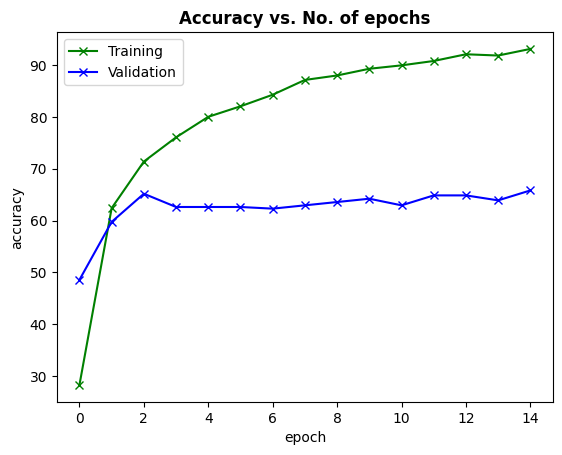

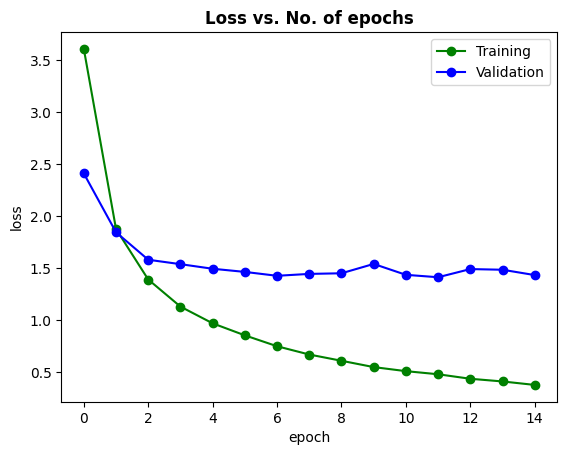

Final accuracy: 82.58680701255798%
Model FLOPs: 1.826082304(GFLOPs)

Baseline model - FLOPs ratio: 5.136497720375412
Accuracy improved: 46.493056416511536%
Model achieved accuracy 2.2881192907008168 times better than baseline model

Model efficiency: 0.4522622382991888 (acc%/GFLOPs)
Model has efficiency 0.4454629234282196 times better than baseline model


In [ ]:
performance_comparison(Resnet18FineTuned(num_classes), 0.001)

In [ ]:
performance_comparison(XceptionTransfer(num_classes), 0.01)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to C:\Users\linhn/.cache\torch\hub\checkpoints\xception-43020ad28.pth
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000018701D927A0>
Traceback (most recent call last):
  File "c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>

Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)


Epoch [1/15], Train Loss: 4.6343, Validation Loss: 3.7341, Train Acc: 15.89%, Validation Acc: 29.07%
Epoch [2/15], Train Loss: 3.8162, Validation Loss: 2.9889, Train Acc: 49.57%, Validation Acc: 40.26%
Epoch [3/15], Train Loss: 3.2682, Validation Loss: 2.5814, Train Acc: 59.91%, Validation Acc: 45.69%
Epoch [4/15], Train Loss: 2.8359, Validation Loss: 2.2848, Train Acc: 67.47%, Validation Acc: 49.52%
Epoch [5/15], Train Loss: 2.5096, Validation Loss: 2.0832, Train Acc: 71.26%, Validation Acc: 51.76%
Epoch [6/15], Train Loss: 2.2461, Validation Loss: 1.9734, Train Acc: 74.13%, Validation Acc: 51.76%
Epoch [7/15], Train Loss: 2.0351, Validation Loss: 1.8576, Train Acc: 76.29%, Validation Acc: 57.51%
Epoch [8/15], Train Loss: 1.8740, Validation Loss: 1.7907, Train Acc: 77.26%, Validation Acc: 58.47%
Epoch [9/15], Train Loss: 1.7118, Validation Loss: 1.7239, Train Acc: 79.23%, Validation Acc: 58.47%
Epoch [10/15], Train Loss: 1.5956, Validation Loss: 1.7180, Train Acc: 80.73%, Validation A

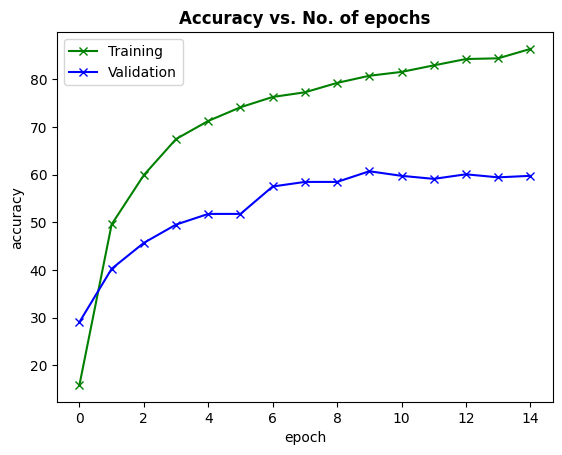

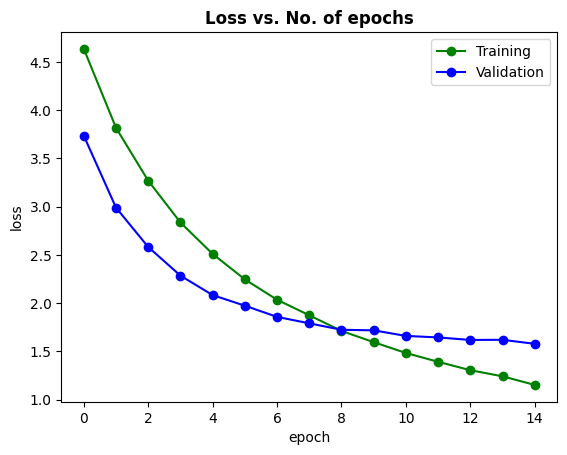

Final accuracy: 81.73611164093018%
Model FLOPs: 0.118696448(GFLOPs)

Baseline model - FLOPs ratio: 0.3338754410100557
Accuracy improved: 45.64236104488373%
Model achieved accuracy 2.264550241832812 times better than baseline model

Model efficiency: 6.886146385857324 (acc%/GFLOPs)
Model has efficiency 6.782619994396676 times better than baseline model


In [ ]:
performance_comparison(MnasNetFineTuned(num_classes), 0.001)

Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::mean encountered 1 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)


Epoch [1/15], Train Loss: 3.2167, Validation Loss: 2.2688, Train Acc: 31.86%, Validation Acc: 47.60%
Epoch [2/15], Train Loss: 1.3483, Validation Loss: 2.2406, Train Acc: 71.01%, Validation Acc: 51.44%
Epoch [3/15], Train Loss: 0.9111, Validation Loss: 2.2426, Train Acc: 80.86%, Validation Acc: 57.83%
Epoch [4/15], Train Loss: 0.6879, Validation Loss: 2.3102, Train Acc: 86.70%, Validation Acc: 51.76%
Epoch [5/15], Train Loss: 0.5262, Validation Loss: 2.2529, Train Acc: 90.77%, Validation Acc: 57.19%
Epoch [6/15], Train Loss: 0.4150, Validation Loss: 2.1963, Train Acc: 93.68%, Validation Acc: 58.79%
Epoch [7/15], Train Loss: 0.3570, Validation Loss: 2.1828, Train Acc: 94.26%, Validation Acc: 58.15%
Epoch [8/15], Train Loss: 0.2938, Validation Loss: 2.1443, Train Acc: 95.91%, Validation Acc: 59.11%
Epoch [9/15], Train Loss: 0.2599, Validation Loss: 2.2591, Train Acc: 96.17%, Validation Acc: 60.38%
Epoch [10/15], Train Loss: 0.2351, Validation Loss: 2.3212, Train Acc: 96.49%, Validation A

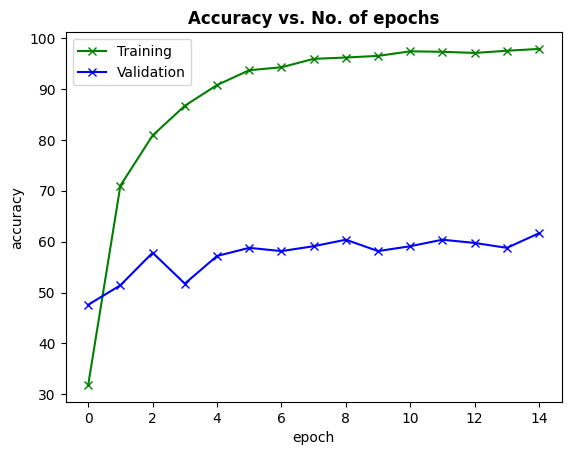

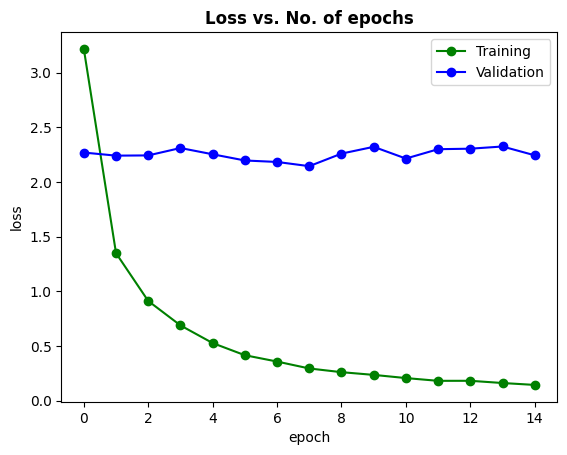

Final accuracy: 79.46759462356567%
Model FLOPs: 0.118696448(GFLOPs)

Baseline model - FLOPs ratio: 0.3338754410100557
Accuracy improved: 43.373844027519226%
Model achieved accuracy 2.201699554943736 times better than baseline model

Model efficiency: 6.695027185949631 (acc%/GFLOPs)
Model has efficiency 6.594374082391478 times better than baseline model


In [ ]:
performance_comparison(MnasNetFineTuned(num_classes), 0.01)